## Homework 6, Assignment 1

In [1]:
from __future__ import print_function, division
import geopandas as gpd
import pandas as pd
import pylab as pl
import os
import json
import urllib2 
import zipfile
import datetime
import urllib
from bokeh.plotting import *
from bokeh.models import HoverTool
from collections import OrderedDict
import statsmodels.formula.api as smf
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['GridSpec', 'Figure', 'figure', 'show', 'save']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


#### An interesting urban question is "can we measure and predict energy use based on observables that are easier to be acquired". For example the urban observatory at CUSP can monitor lights: they are a realtively easy observable. All you need is a camera, and a pipeline to process your data. But how does the light coming from a window relate to the total energy consumption? We generally postulate that light is a proxy for occupancy, and that occupancy is a good predictor of energy consumption.
#### So let's test if the last link holds. If we have data on the energy consumed by a __building__ how well does that relate to the number of units in the building?

#### Data on energy consumption can be found here for the city of NY https://data.cityofnewyork.us/Environment/Energy-and-Water-Data-Disclosure-for-Local-Law-84-/rgfe-8y2z  

#### Either obtain the data through the API or download the csv file, and move it to $PUIDATA

#### However this datasets does not have the number of units. We can find that in the Pluto dataset.

#### Reading in the Pluto data for manhattan, which will give me the number of units ber building   Manhattan/MNMapPLUTO.shp

In [2]:
#Get Energy data using API call, then load that data into a dataframe. 
#https://dev.socrata.com/foundry/data.cityofnewyork.us/7drc-shp9
query = ("https://data.cityofnewyork.us/resource/m46j-75iy.json")
raw_data = pd.read_json(query)	
df_nrg = pd.DataFrame(raw_data)

In [3]:
##Get Pluto data, move to PUIDATA folder, and read it using Geopandas into a dataframe. 
!curl -O "http://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/mn_mappluto_16v1.zip"
os.rename("mn_mappluto_16v1.zip", "../PUIDATA/mappluto.zip")
plutozip="../PUIDATA/mappluto.zip"
zf = zipfile.ZipFile(plutozip, mode='r')
zf.extractall("../PUIDATA/")
zf.close()
plutofile = "MNMapPLUTO.shp"

#geopandas reader resource: http://geopandas.org/io.html
bsize = gpd.read_file(os.getenv('PUI2016') + '_bja282/PUIDATA/' + plutofile) 


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 11.6M  100 11.6M    0     0  51.0M      0 --:--:-- --:--:-- --:--:-- 56.1M


In [4]:
df_nrg.columns

Index([u'automatic_water_benchmarking_eligible', u'bbls_co_reported',
       u'borough', u'co_reported_bbl_status', u'direct_ghg_emissions_mtco2e',
       u'dof_benchmarking_submission_status', u'dof_number_of_buildings',
       u'dof_property_floor_area_buildngs_and_parking_ft2',
       u'energy_star_score', u'indirect_ghg_emissions_mtco2e',
       u'municipally_supplied_potable_water_indoor_intensity_gal_ft',
       u'nyc_borough_block_and_lot_bbl',
       u'primary_property_type_self_selected', u'record_number',
       u'reported_nyc_building_identificaiton_numbers_bins',
       u'reported_property_floor_area_building_s_ft', u'reported_water_method',
       u'site_eui_kbtu_ft2', u'source_eui_kbtu_ft2', u'street_name',
       u'street_number', u'total_ghg_emissions_mtco2e',
       u'weather_normalized_site_eui_kbtu_ft2',
       u'weather_normalized_source_eui_kbtu_ft2', u'zip_code'],
      dtype='object')

In [5]:
bsize.columns

Index([    u'APPBBL',    u'APPDate',    u'Address', u'AllZoning1',
       u'AllZoning2', u'AreaSource', u'AssessLand',  u'AssessTot',
              u'BBL',   u'BldgArea',  u'BldgClass',  u'BldgDepth',
        u'BldgFront',      u'Block',   u'BoroCode',    u'Borough',
         u'BsmtCode',  u'BuiltCode',   u'BuiltFAR',     u'CB2010',
               u'CD',     u'CT2010',    u'ComArea',    u'CommFAR',
          u'CondoNo',    u'Council',  u'EDesigNum',  u'Easements',
       u'ExemptLand',  u'ExemptTot',        u'Ext',   u'FacilFAR',
       u'FactryArea',   u'FireComp', u'GarageArea', u'HealthArea',
         u'HistDist', u'IrrLotCode',    u'LandUse',   u'Landmark',
              u'Lot',    u'LotArea',   u'LotDepth',   u'LotFront',
          u'LotType',  u'LtdHeight', u'MAPPLUTO_F',   u'NumBldgs',
        u'NumFloors', u'OfficeArea',  u'OtherArea',   u'Overlay1',
         u'Overlay2',  u'OwnerName',  u'OwnerType', u'PLUTOMapID',
       u'PolicePrct',   u'ProxCode',    u'ResArea',   u'ResidF

In [6]:
# make sure you clean up your data and throw away columns you do not need!
bsize = bsize[['UnitsTotal','BBL']]
df_nrg = df_nrg[['zip_code', 'site_eui_kbtu_ft2', 'nyc_borough_block_and_lot_bbl', 'reported_property_floor_area_building_s_ft']]
print(bsize.columns, df_nrg.columns)

Index([u'UnitsTotal', u'BBL'], dtype='object') Index([u'zip_code', u'site_eui_kbtu_ft2', u'nyc_borough_block_and_lot_bbl',
       u'reported_property_floor_area_building_s_ft'],
      dtype='object')


In [7]:
bsize.head()

,UnitsTotal,BBL
0,18,1.015450e+09
1,50,1.007238e+09
2,10,1.016800e+09
3,32,1.013850e+09
4,26,1.011970e+09


In [8]:
df_nrg.head()

,zip_code,site_eui_kbtu_ft2,nyc_borough_block_and_lot_bbl,reported_property_floor_area_building_s_ft
0,NaN,NaN,1.000410e+09,918919
1,11375.0,NaN,4.021460e+09,#N/A
2,NaN,NaN,2.027620e+09,64200
3,10001.0,NaN,1.006700e+09,#N/A
4,NaN,NaN,2.048300e+09,50000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1349bb98d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f136010ee10>]], dtype=object)

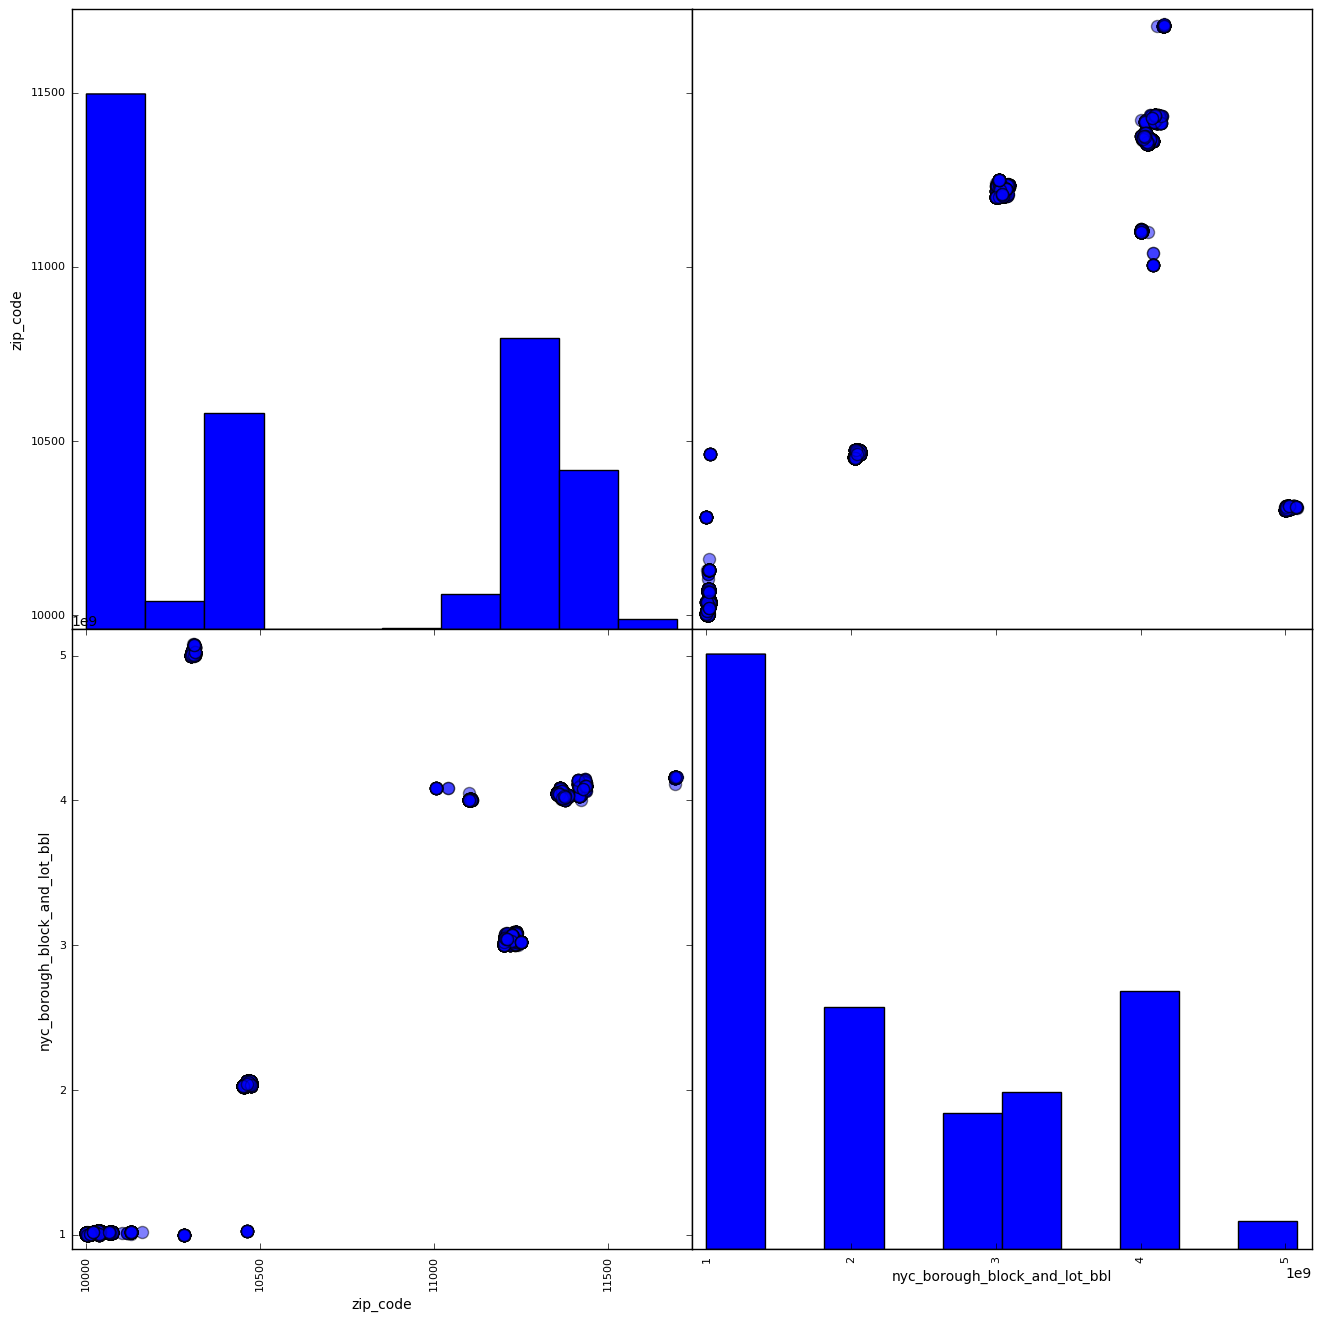

In [9]:
#try make a scatter plot of nrg. Few columns will plot
from pandas.tools.plotting import scatter_matrix
scatter_matrix (df_nrg, s=300, figsize=(16, 16))

Figure 1: scatter matrix of all numerical values in the files.

This kind of plot shows correlations between variables, but it will also show me what can and cannot be plotted trivially in my dataset. Here only a few columns can be plotted: those that contain only numbers (and possibly NaN's), but most columns contain rows that cannot be converted to float (e.g. entries like 'See Primary BBL' in several rows for the energy dataframe 'Site EUI(kBtu/ft2) ' column) , so Pandas refuses to plot them, cause it does not know what to do with those entries. The columns I am interested in are in fact u'Site EUI(kBtu/ft2)' which is a measure of the energy consumed PER SQ FOOT by a building, and then the building area: for eg. u'Reported Property Floor Area (Building(s)) (ft²)'. Neither gets plotted: i need to remove all values that cannot conver to float in order to use the columns and convert them to float arrays and do math with them.
Below I created a function that returns True if what is passed as argument can be converted to a float, and False otherwise. I do it with the Try/Except structure. it is a very useful python functionality that you should look into.
This has to be done entry by entry: if you give it a series you get error "cannot convert the series to..."
However you can pass it a whole array by using it in conjunction with np.vectorize (look up the syntax!) which will implement a for loop for you under the hood to pass the series entry by entry to your function.

In [10]:
pd.to_numeric(df_nrg['site_eui_kbtu_ft2'], errors='coerce')
pd.to_numeric(df_nrg['reported_property_floor_area_building_s_ft'], errors='coerce')

0        918919.0
1             NaN
2         64200.0
3             NaN
4         50000.0
5         61800.0
6        102198.0
7         46620.0
8             NaN
9         54029.0
10            0.0
11       171502.0
12            NaN
13        68750.0
14            NaN
15            NaN
16       330000.0
17            NaN
18        69160.0
19        52974.0
20        82200.0
21        63360.0
22        52960.0
23            NaN
24            NaN
25       154754.0
26       465667.0
27            NaN
28        68329.0
29        66546.0
           ...   
16140         NaN
16141         NaN
16142         NaN
16143         NaN
16144         NaN
16145         NaN
16146         NaN
16147         NaN
16148         NaN
16149         NaN
16150         NaN
16151         NaN
16152         NaN
16153         NaN
16154         NaN
16155         NaN
16156         NaN
16157         NaN
16158         NaN
16159         NaN
16160         NaN
16161         NaN
16162         NaN
16163         NaN
16164     


Now for every column I care about I can create an array, call it for eg. indx, of True and False (a Boolean array) that i can use as an index to pick entries that I want to use from my arrays of interest. 

I can replace the entries that failed to be converted to 'NaN'
(because my function return Trues when I can convert and False otherwise i actuallly want the complementary array: ~indx) 

In [11]:
##check that your conversion worked: e.g.
#print (df_nrg['site_eui_kbtu_ft2'].astype(float))
#[...] check all columns you care about in both datasets. 
#Nan's are ok, but you must not get an error when you try the conversion
#the Pluto data is much better at not using spurious entries for numerical value columns. 
#but check you can use the columns you want
bsize.BBL.astype(float)
#this should not return an error
#notice i can use the attribute notation to refer to columns in bsize, 
#cause the column names do not have spaces!

0        1.015450e+09
1        1.007238e+09
2        1.016800e+09
3        1.013850e+09
4        1.011970e+09
5        1.002360e+09
6        1.008370e+09
7        1.001960e+09
8        1.022240e+09
9        1.011270e+09
10       1.011650e+09
11       1.021740e+09
12       1.009120e+09
13       1.007920e+09
14       1.012110e+09
15       1.011240e+09
16       1.009040e+09
17       1.010090e+09
18       1.020620e+09
19       1.020630e+09
20       1.008940e+09
21       1.005728e+09
22       1.004400e+09
23       1.019470e+09
24       1.008830e+09
25       1.020810e+09
26       1.021610e+09
27       1.008570e+09
28       1.008830e+09
29       1.020410e+09
             ...     
42667    1.014738e+09
42668    1.006208e+09
42669    1.007218e+09
42670    1.013428e+09
42671    1.019448e+09
42672    1.017298e+09
42673    1.018488e+09
42674    1.005008e+09
42675    1.020448e+09
42676    1.004518e+09
42677    1.020958e+09
42678    1.007688e+09
42679    1.008498e+09
42680    1.017298e+09
42681    1

In [12]:
#example
indx = (pd.to_numeric(df_nrg['site_eui_kbtu_ft2'], errors=coerce))
print ("invalid entries changed to NaN %d"%sum(indx))
#df_nrg['site_eui_kbtu_ft2'][~indx] = float('NaN')
#do it for however many columns you need

invalid entries changed to NaN 35988272


# MERGE THE DATASET
TO DO IT WE NEED A COMMON COLUMN: the building id BBL However the name of this variable (column) in the Energy dataset is 'NYC Borough, Block, and Lot (BBL)'. create a column 'BBL' in the nrg dataset to pass it to the 'on' keyword argument of the merge pandas method: pd.merge(..... on=['BBL']) will use the common column 'BBL' to join the information from the 2 datasets for each BBL value (check out the complete syntax!)

In [13]:
df_nrg.columns

Index([u'zip_code', u'site_eui_kbtu_ft2', u'nyc_borough_block_and_lot_bbl',
       u'reported_property_floor_area_building_s_ft'],
      dtype='object')

In [14]:
# prepare your BBL columns
df_nrg.rename(columns={'nyc_borough_block_and_lot_bbl':'BBL'}, inplace=True)
#merge
bblnrgdata = pd.merge(df_nrg, bsize, how='inner', on='BBL')

bblnrgdata
# Now the scatter matrix plot should show more columns.
#scatter_matrix (bblnrgdata, s=30, figsize=(16, 16))

,zip_code,site_eui_kbtu_ft2,BBL,reported_property_floor_area_building_s_ft,UnitsTotal
0,10001.0,NaN,1.006700e+09,#N/A,1
1,10009.0,NaN,1.004370e+09,#N/A,4
2,10022.0,125.4,1.013110e+09,330000,56
3,10003.0,NaN,1.009220e+09,#N/A,148
4,NaN,NaN,1.007400e+09,68329,1
5,NaN,NaN,1.012770e+09,66546,16
6,NaN,NaN,1.008830e+09,58456,3
7,10002.0,NaN,1.002830e+09,#N/A,1
8,NaN,NaN,1.008210e+09,73000,13
9,10010.0,NaN,1.008240e+09,74027,11


once you have the dataframe with all the info you want, you want to plot Energy vs Number of Units in the Building. Remember: **Energy TOTAL, not per sq ft...** Here you can choose what you think makes more sense for the number of units: all units, residential units... 

**Make a  scatter plot first of Energy vs Units. It will look really bad be cause all the datapoints are at very low Unit numbers while the Unit number range actually goes up to 8000. **


Make a second plot that zooms into the region where most points are by cutting your x and y axis plotted: e,g, use xlim=(1000,1e10), ylim=(1,1000), where the numbers to be plugged in depend on exactly what you chose to plot

I left my plots below as guidance. **Remember, each plot needs a descriptive caption, and axis labels**

In [15]:
bblnrgdata.columns

Index([                                  u'zip_code',
                                u'site_eui_kbtu_ft2',
                                              u'BBL',
       u'reported_property_floor_area_building_s_ft',
                                       u'UnitsTotal'],
      dtype='object')

,zip_code,Site EUI - kbtu/ft2,BBL,Floor Area - building sq ft.,UnitsTotal
0,10001.0,NaN,1.006700e+09,#N/A,1
1,10009.0,NaN,1.004370e+09,#N/A,4
2,10022.0,125.4,1.013110e+09,330000,56
3,10003.0,NaN,1.009220e+09,#N/A,148
4,NaN,NaN,1.007400e+09,68329,1


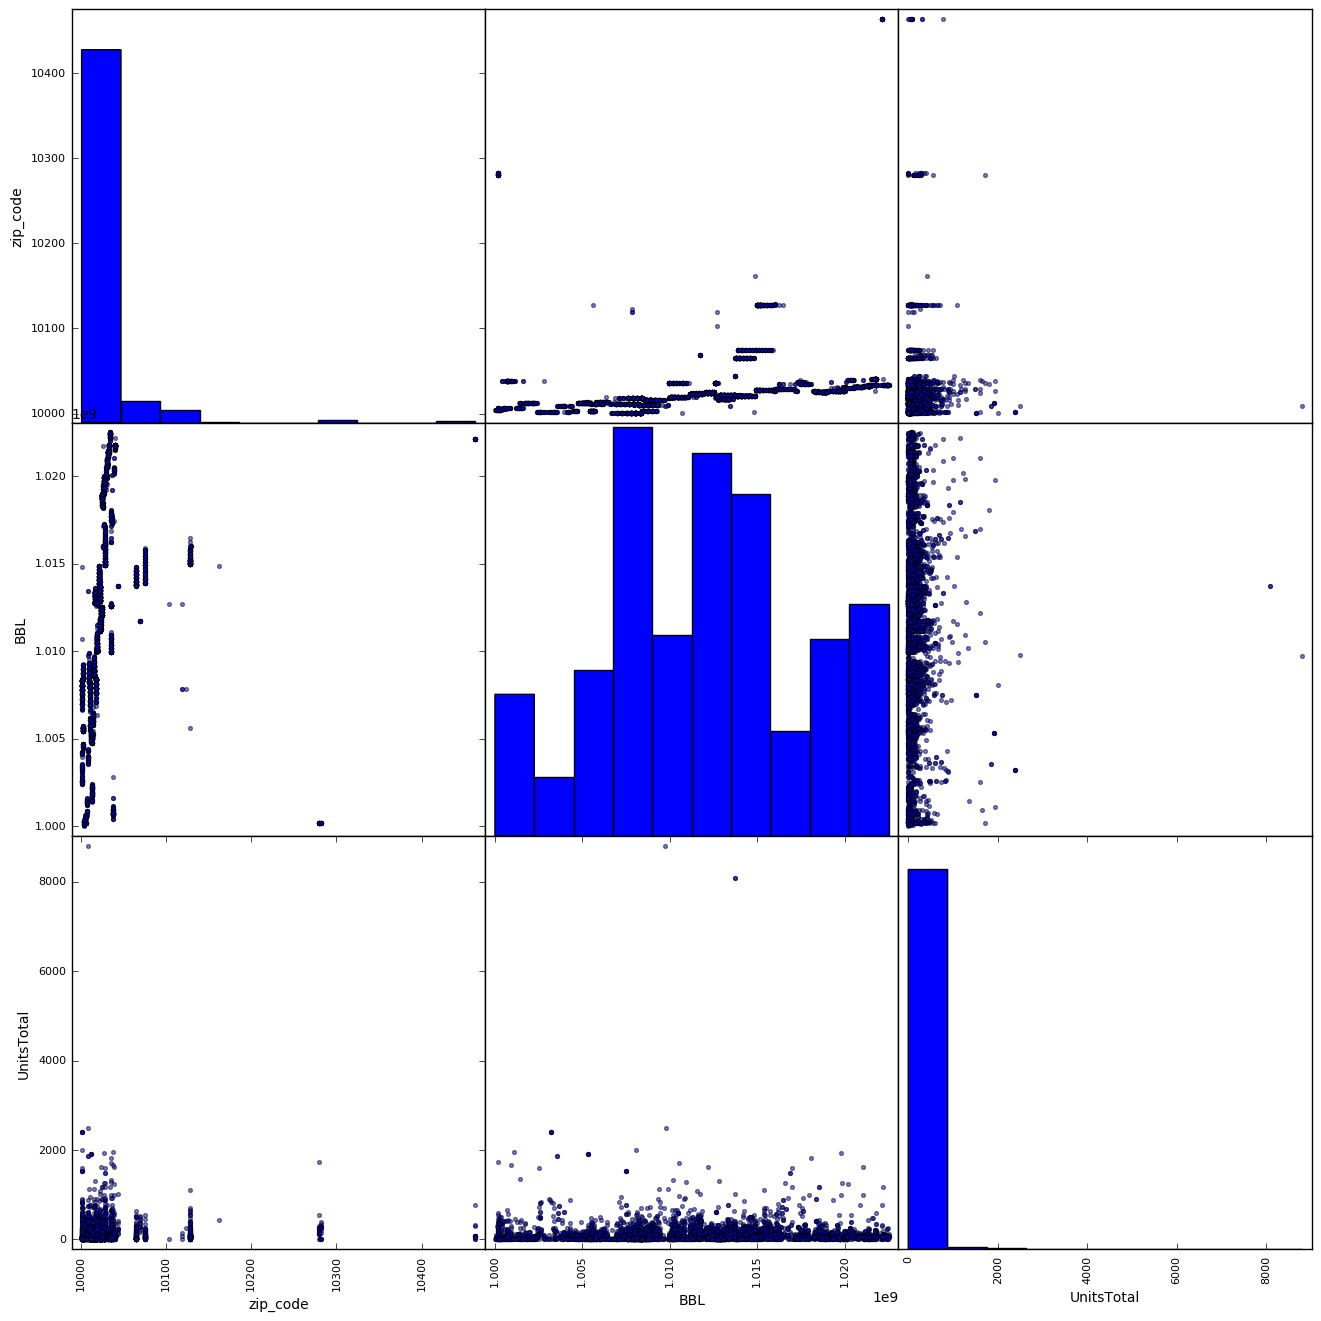

In [16]:
#Clean up column names
bblnrgdata.rename(columns={'site_eui_kbtu_ft2':'Site EUI - kbtu/ft2', 'reported_property_floor_area_building_s_ft':'Floor Area - building sq ft.'}, inplace=True)
#Scatter Matrix
#Pandas: scatter_matrix(df, alpha=0.2, figsize=(6, 6), diagonal='kde')
scatter_matrix (bblnrgdata, s=30, figsize=(16, 16))
bblnrgdata.head()

In [17]:
pd.to_numeric(bblnrgdata['Floor Area - building sq ft.'], errors='coerce')

0            NaN
1            NaN
2       330000.0
3            NaN
4        68329.0
5        66546.0
6        58456.0
7            NaN
8        73000.0
9        74027.0
10      841709.0
11      426531.0
12      220624.0
13      250000.0
14      340574.0
15       59468.0
16      364000.0
17       78678.0
18      235370.0
19       64806.0
20       62839.0
21       98000.0
22      204417.0
23       60110.0
24      457946.0
25      511001.0
26       56442.0
27       60939.0
28       78435.0
29       80293.0
          ...   
6462         NaN
6463         NaN
6464         NaN
6465         NaN
6466         NaN
6467         NaN
6468         NaN
6469         NaN
6470         NaN
6471         NaN
6472         NaN
6473         NaN
6474         NaN
6475         NaN
6476         NaN
6477         NaN
6478         NaN
6479         NaN
6480         NaN
6481         NaN
6482         NaN
6483         NaN
6484         NaN
6485         NaN
6486         NaN
6487         NaN
6488         NaN
6489         N

In [18]:
# First Scatter Plot
bblnrgdata['Energy Total'] = (pd.to_numeric(bblnrgdata['Site EUI - kbtu/ft2'], errors=coerce) * pd.to_numeric(bblnrgdata['Floor Area - building sq ft.'], errors=coerce))
#Removing energy totals less than 1000 units and units that are equal to '0'
bblnrgdata = bblnrgdata[((bblnrgdata['Energy Total'] >= 1000) & (bblnrgdata.UnitsTotal != 0) )]
bblnrgdata.head()

#bblnrgdata.plot(x='Energy Total', y='UnitsTotal', style='o', figsize=(16, 16), title="First Scatter Plot")

,zip_code,Site EUI - kbtu/ft2,BBL,Floor Area - building sq ft.,UnitsTotal,Energy Total
2,10022.0,125.4,1.013110e+09,330000,56,41382000.0
10,NaN,154.9,1.010140e+09,841709,2,130380724.1
15,10011.0,122.3,1.007660e+09,59468,8,7272936.4
16,10018.0,117,1.008150e+09,364000,24,42588000.0
18,10013.0,82.1,1.005050e+09,235370,24,19323877.0


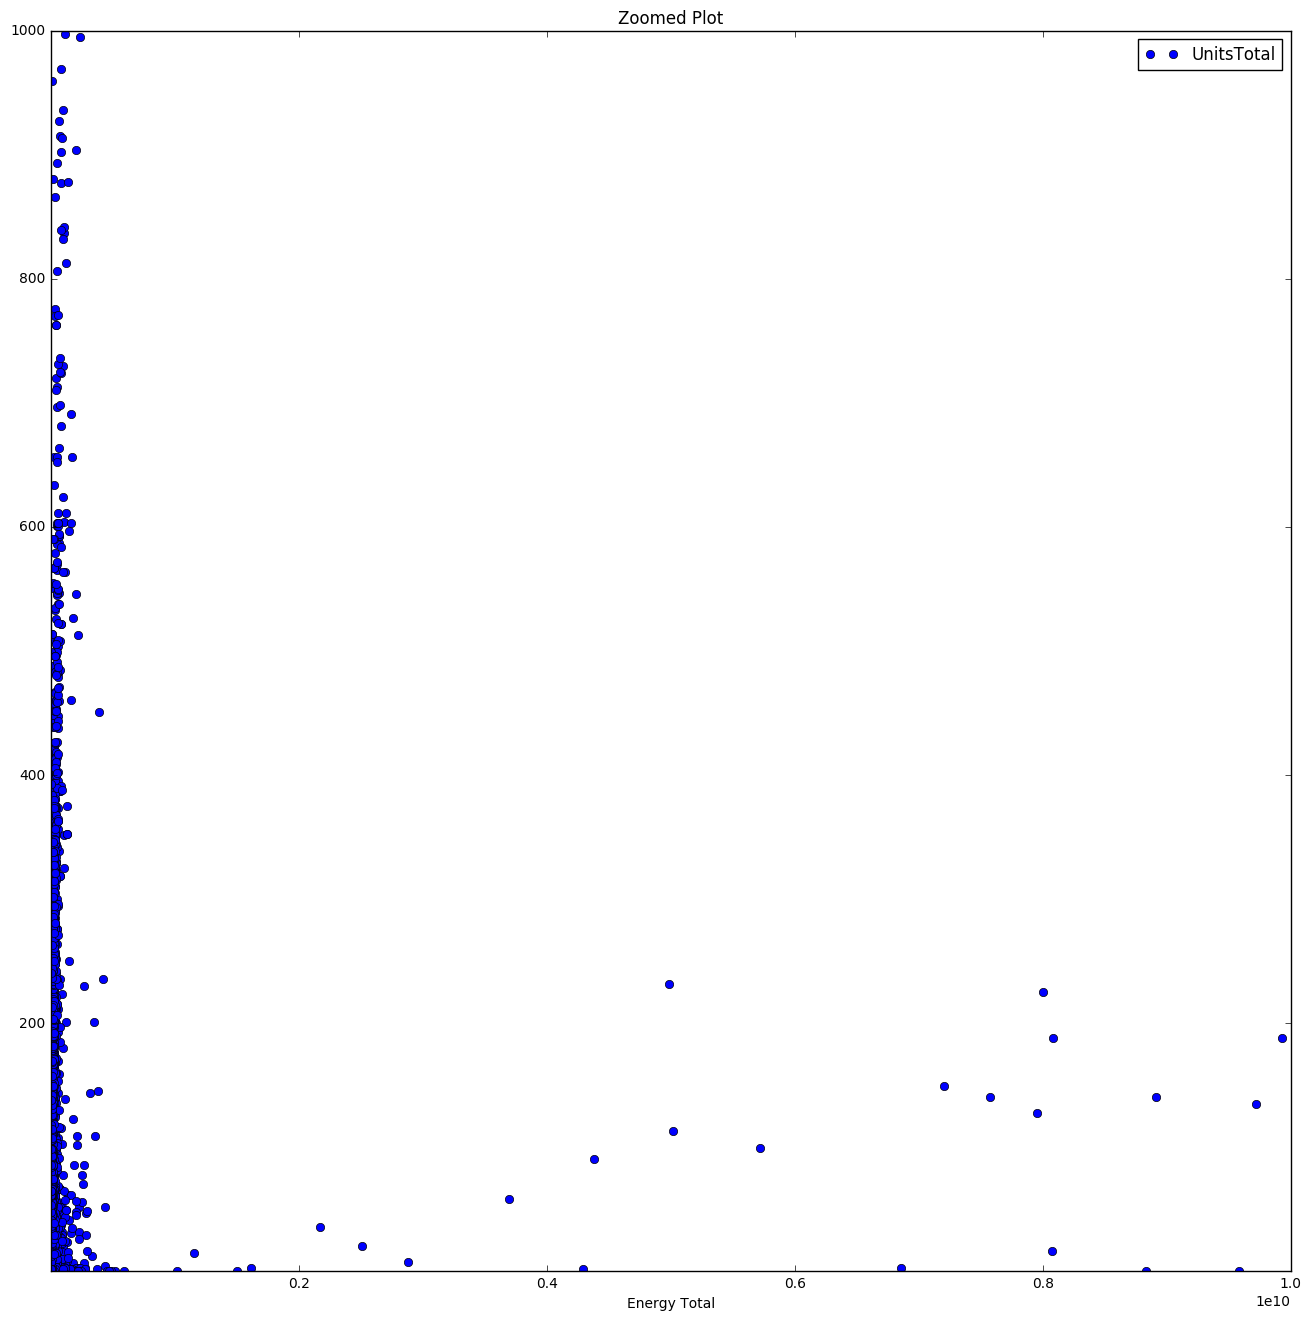

In [19]:
# Zoomed Scatter Plot
bblnrgdata.plot(x='Energy Total', y='UnitsTotal', style='o', figsize=(16, 16),xlim=(1000,1e10), ylim=(1,1000), title="Zoomed Plot")

when the points in a plot all look scrunched against the axis 

**Try to make a log plot instead**. In pandas you enable that with the keyword 'loglog' : bblnrgdata.plot(..... loglog=True)

NOTICE THAT YOU WILL STILL HAVE TO CUT YOUR DATASET! in my data I had a lot of energy datapoints that were exactly 0. I removed these "outliers" which I think are truly outliers in the sense that they are misreported numbers. you can remove the data that have nrg==0 (or nrg < some sensible threshold choice) by indexing your array: something like bblnrgdata_cut = bblnrgdata[bblnrgdata.nrg>1000]

Also I removed the buildings with several thousand units. points like that at the edge of my range would have a lot of "LEVERAGE", however they are not suprious entries like the 0, which i believe are missing values, or perhaps abandoned lots. these are good datapoint that i need to throw away functionally for my analysis to work, but that should be stated clearly.



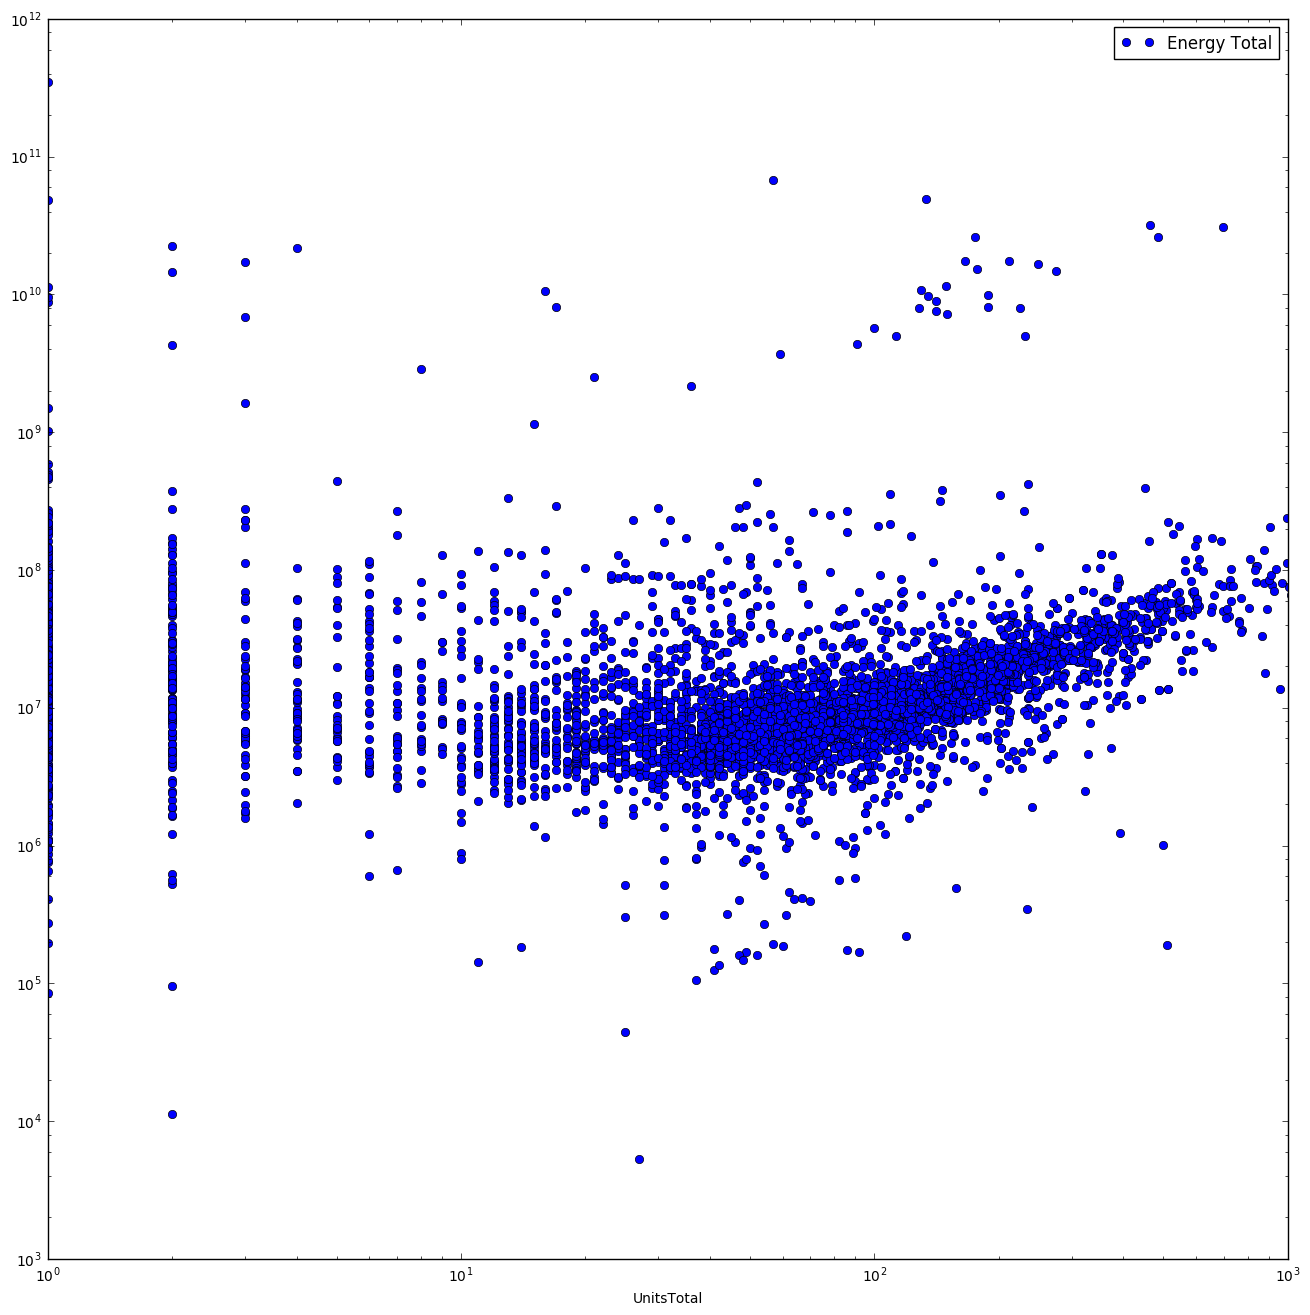

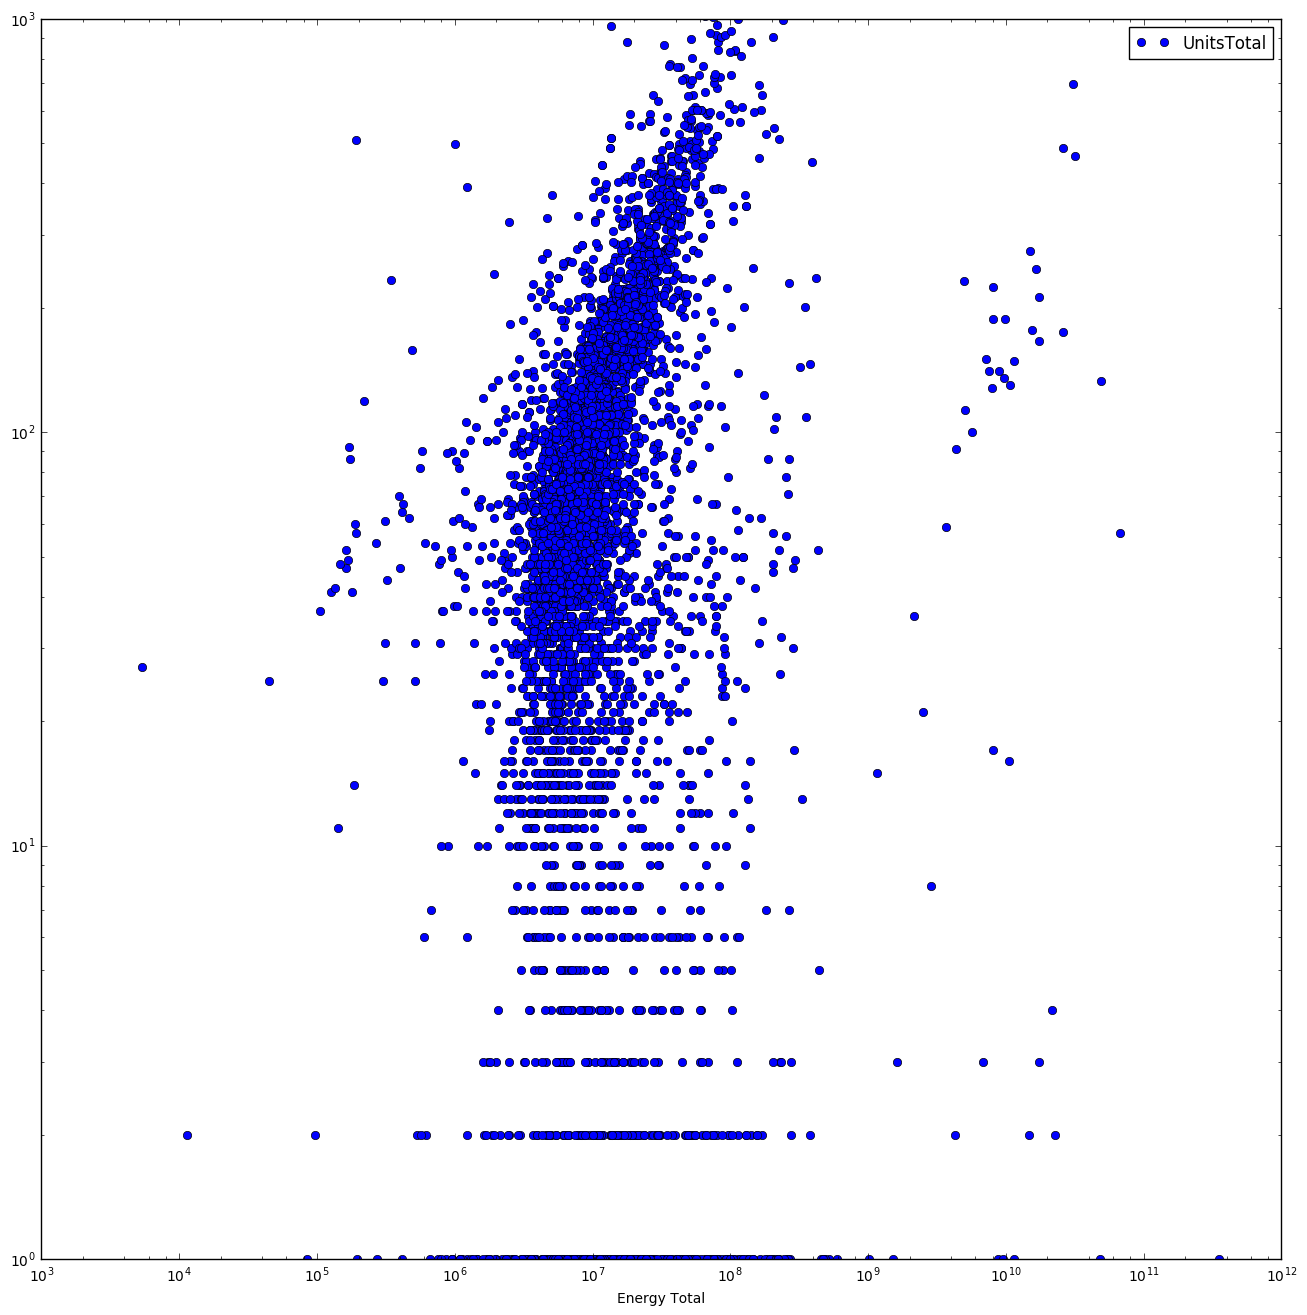

In [20]:
#log plot
bblnrgdata.plot(x='UnitsTotal', y='Energy Total', figsize=(16, 16),xlim=(1,1000), ylim=(1000,1e12), loglog=True, style='o')
bblnrgdata.plot(x='Energy Total', y='UnitsTotal', figsize=(16, 16),xlim=(1000,1e12), ylim=(1,1000), loglog=True, style='o')

Now fit a line through the data. you can use whatever you want to do it: statsmodels, scipy, any other package, or write your own minimization of the residuals

## BUT REMEMBER: we see hints of a linear relation in log space! so we want to fit a line to the log of our variables, not the variables themselves:
if you used statsmodels it would look something like this:


In [21]:
x = bblnrgdata['UnitsTotal']
X = sm.add_constant(np.log10(x))
linmodel = sm.OLS(np.log10(bblnrgdata['Energy Total']), X, missing='drop').fit() # ignores entires 
                                                     # where x or y is NaN
linmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Energy Total   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     63.79
Date:                Wed, 19 Oct 2016   Prob (F-statistic):           1.70e-15
Time:                        00:49:24   Log-Likelihood:                -3867.6
No. Observations:                4997   AIC:                             7739.
Df Residuals:                    4995   BIC:                             7752.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          6.9116      0.020    353.804      0.000         6.873     6.950
UnitsTotal     0.0865      0.011      7.987      0.000         0.065     0.108
==============================================================================
Omnibus:                     2221.478   Durbin-Watson:                   1.686
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            27205.366
Skew:                           1.791   Prob(JB):                         0.00
Kurtosis:                      13.855   Cond. No.                         6.04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## choose wisely which is your DEPENDENT and which is your INDEPENDENT variable. 
both for what you want to do logically (what changes as a functino of what) but also based on which variable has a 'sensible' distribution that allows you to fit a function to it: **you need your independent variable to span a large range, and to be spread somewhat evenly in the range, rather than just clustered in a spot** so in this case switching the independent and dependent variable may be a good idea.

1. **Fit a line** to Units vs Energy.

2. **Fit a line** to Energy vs Units.

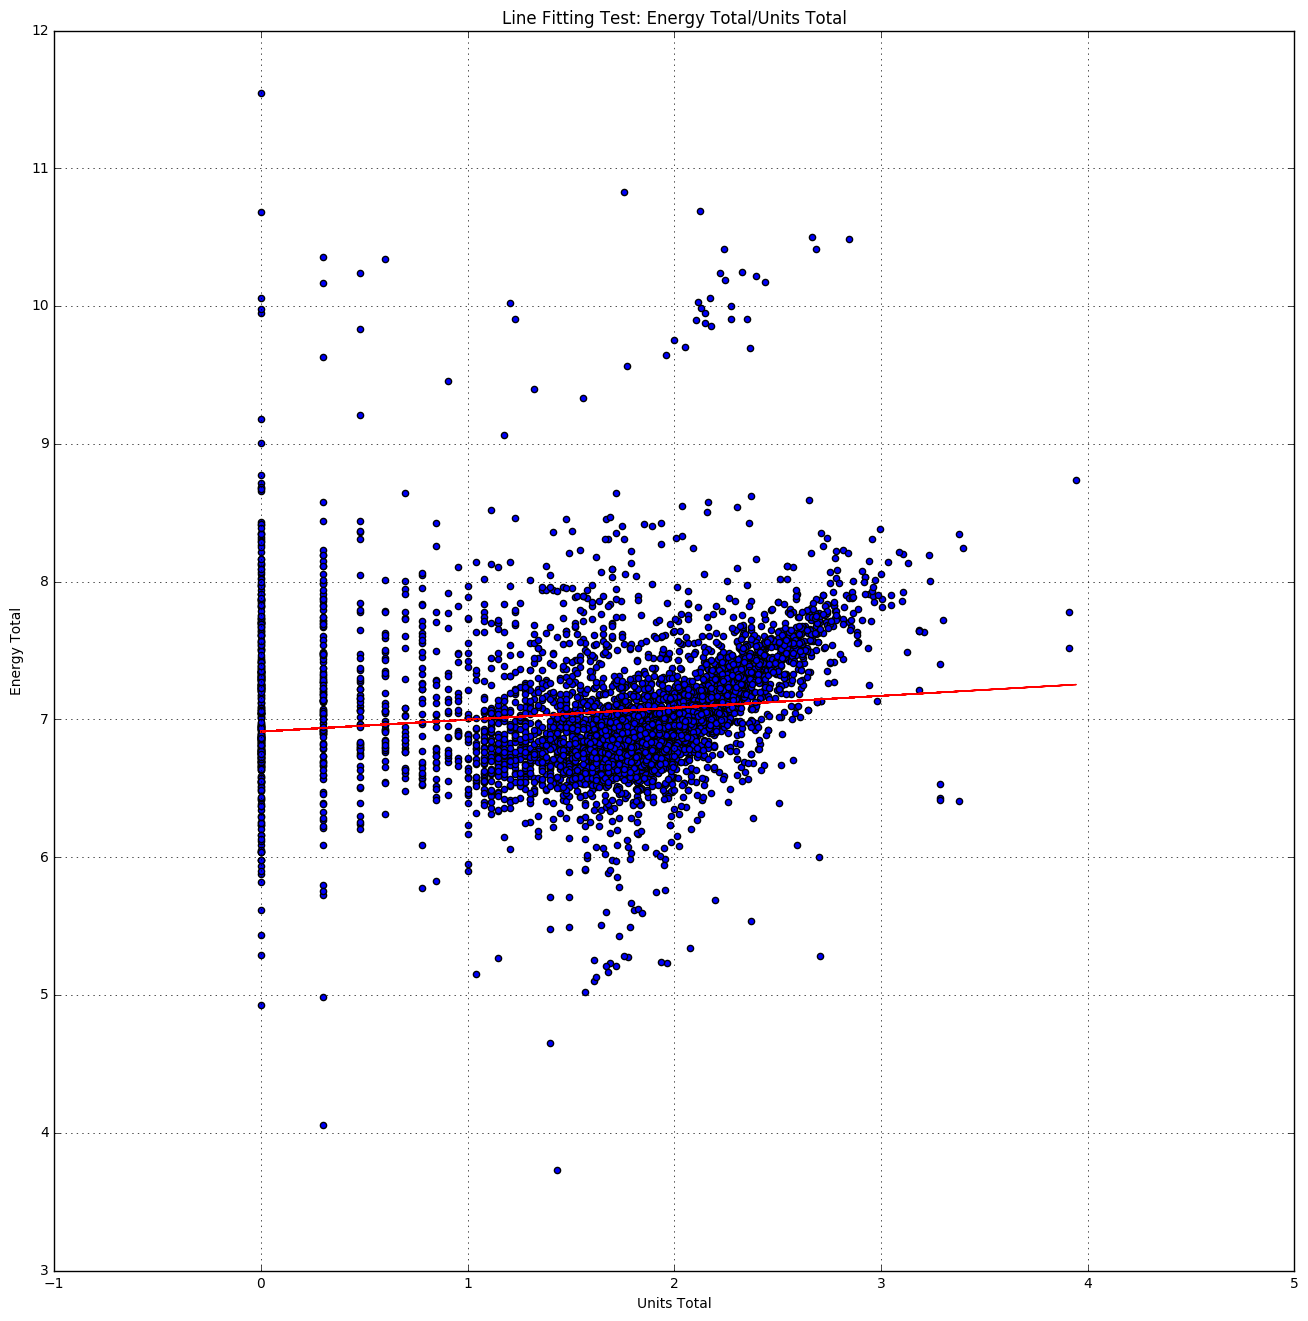

In [162]:
# fits and plots here
# your plots should show datapoints (as scatter plot) and models (as lines)
#Very helpful: https://www.wired.com/2011/01/linear-regression-with-pylab/
logunits=np.log10(bblnrgdata['UnitsTotal'])
lognrg=np.log10(bblnrgdata['Energy Total'])

(m,b) = polyfit(logunits,lognrg,1)
yp = polyval([m,b],logunits)


##1. Fit a line to units v. energy
pl.figure(figsize=(16,16))
pl.title('Line Fitting Test: Energy Total/Units Total')
pylab.xlabel('Units Total')
pylab.ylabel('Energy Total')
#pl.xlim(-1, 10)
#pl.ylim(7, 28)
pl.scatter(logunits, lognrg)
pl.plot(logunits, yp, color="red")
grid(True)
pl.show()

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


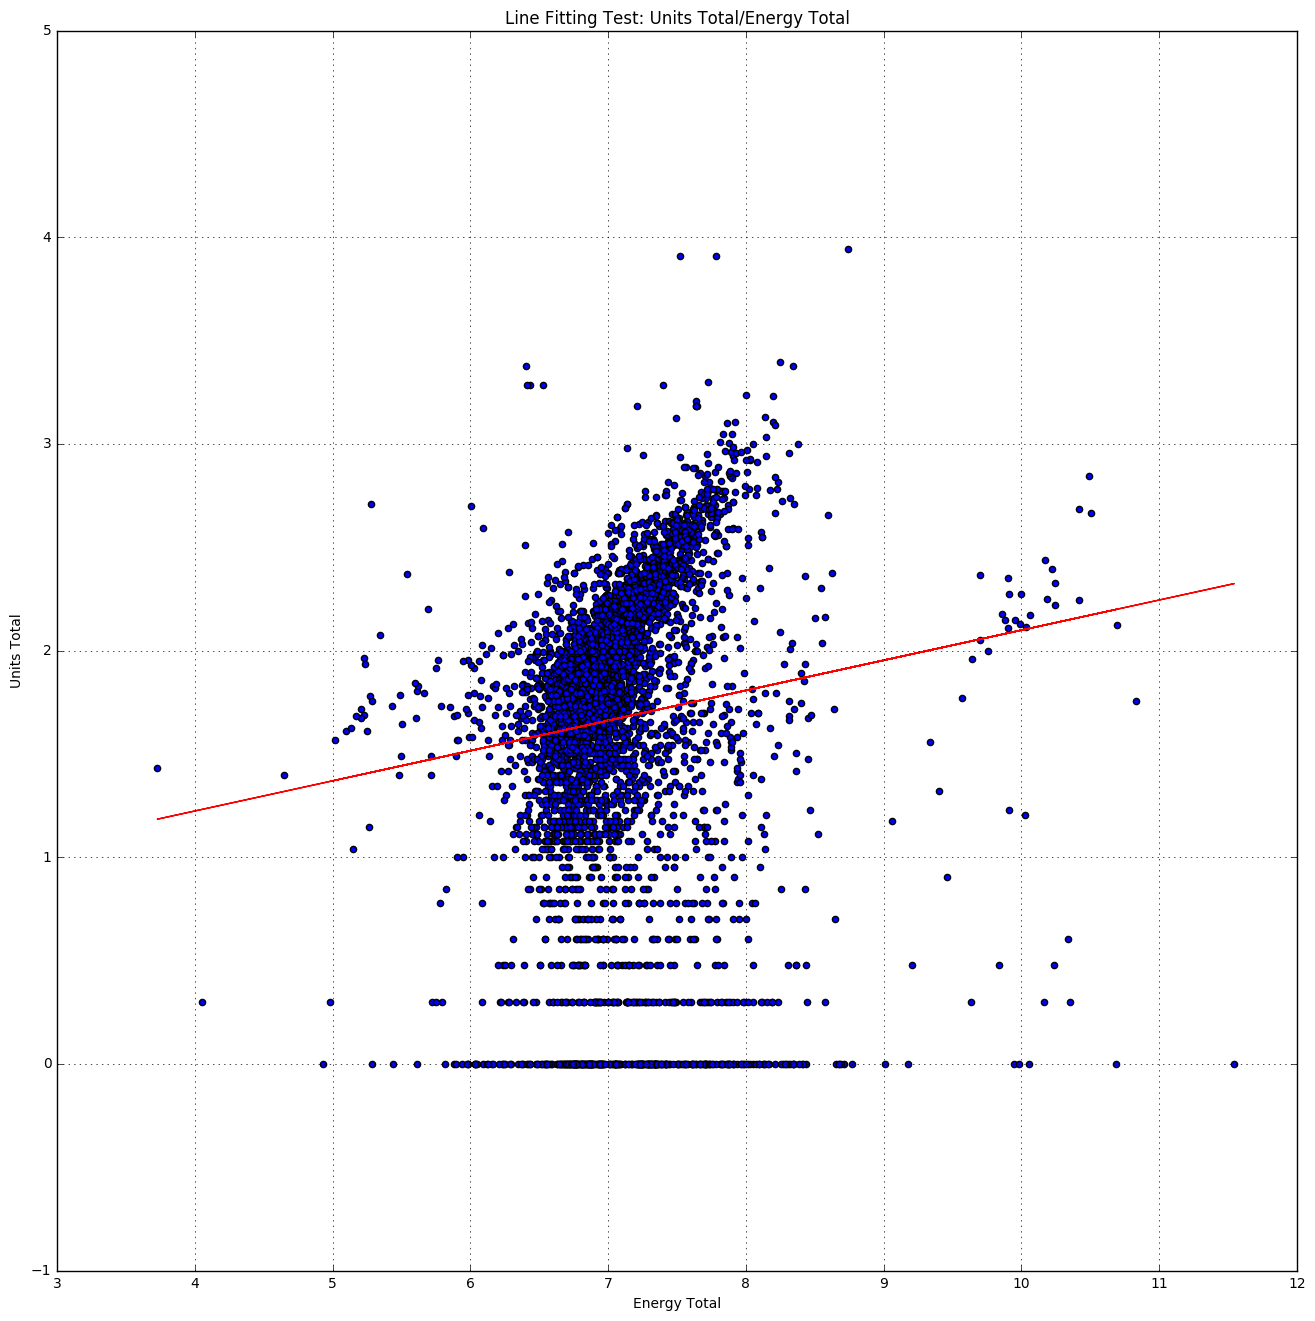

In [161]:
bblnrgdata['logenergy']=np.log10(bblnrgdata['Energy Total'])
bblnrgdata['logunits']=np.log10(bblnrgdata['UnitsTotal'])
y=np.log10(bblnrgdata['UnitsTotal'])
x=np.log10(bblnrgdata['Energy Total'])

(m,b) = polyfit(x,y,1)
yp = polyval([m,b],x)

pl.figure(figsize=(16,16))
pl.title('Line Fitting Test: Units Total/Energy Total')
pylab.xlabel('Energy Total')
pylab.ylabel('Units Total')
#pl.ylim(-1, 10)
#pl.xlim(3, 8)
pl.scatter(x, y)
pl.plot(x, yp, color="red")
grid(True)
pl.show()

#3. **Evaluate which is better by calculating the chi square**. I provide a function for that or you can write your own. *Assume poisson statistics for the errors on the independent variable*. 
    The function is
    
chisq = $\sum_i \frac{(model(x_i) - data(x_i))^2 }{ error_i^2}$
    
where the sum is over all datapoints, 
    
for the i-th value with x value $x_i$ model is the predction of your fit for $x_i$, 
    
$data(x_i)$ 
is your observation, 
    
and $error_i$ is $\sqrt{data(x_i)}$
(but remember you worked in log space! What are the proper errors??)

In [166]:
# scipy.stats.chisquare(f_obs, f_exp=None, ddof=0, axis=0)


# from HW4, need to adjust for errors in log space
# http://faculty.washington.edu/stuve/log_error.pdf --> observations = log(y), so error of obs = error of log(y)
# def evalChisq(model, data):
#    model = linmodel
#    data = #observations, i.e. the point from bblnrg.plot(x='UnitsTotal', y='TotalEnergy', style='o', xlim=(10,1000), 
#           # ylim=(10000,1e11), figsize=(16, 16), loglog=True, title = 'Energy Consumption (kBtu)')
#    for j in range(len(model[0])):
#        for i in range(2):
#            E = (np.sqrt(log10(data)))
#    return ((model - data)**2 / E).sum()

#Energy = 10** param0 * Units**param1
#You then make an array of (predictEnergy - Energy) / sqrt(Energy) 
#and sum the squares of that vector. That is the Chi2 statistic, if I am understanding things correctly.

#param[ i ] is a reference to OLSmodel.params[ i ].
x = bblnrgdata['UnitsTotal']
X = sm.add_constant(np.log10(x))
Y=np.log(bblnrgdata['Energy Total'])
linmodel = sm.OLS(np.log10(bblnrgdata['Energy Total']), X, missing='drop')

model = sm.OLS(Y,X)
results = linmodel.fit()
results.params

#const         6.911571
#UnitsTotal    0.086466

Energy = 10 ** 6.911571 * len(bblnrgdata['UnitsTotal'] * .086466)

print("I was unfortunately unable to figure this out.")

I was unfortunately unable to figure this out.


#4. **Fit a 2nd degree polynomial** to the Units vs Energy (with statsmodels.formulae.api.ols() for example passing the formula for a parabola, like we did in class. The formula for a 2nd deg polynomial is 
    $y = ax^2+bx+c$ .

In [164]:
# Curve Fitting:  scipy.optimize.curve_fit(f, xdata, ydata, p0=None, sigma=None, absolute_sigma=False, 
# check_finite=True, bounds=(-inf, inf), method=None, jac=None, **kwargs)
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chisquare.html

print("I was unfortunately unable to figure this out.")

I was unfortunately unable to figure this out.


#5. **Compare the Units vs Energy line fit and the Units vs Energy 2-nd degree polynomial fit with the Likelihood ratio test**. The formula is:
   
   LR  =  -2 * (logLikelihood_Model1 - logLikelihood_Model2)
    
   where Model1 is the least complex (fewer parameters).
    
   The logLikelihood can be extracted from the model summary when using statsmodels.
    
   Compare this LR statistics to a chi sq table (for example http://passel.unl.edu/Image/Namuth-CovertDeana956176274/chi-sqaure%20distribution%20table.PNG) and say if *at alpha = 0.05* Model1 is preferible to Model2. The LR is chi^2 distributed with number of degrees of freedom N_{DOF} = parameters_Model2 - parameters_Model1
    
    
    Also if you used statsmodels for the fit you can use the 
    compare_lr_test() method of your fit and verify you got the right answer.  Use the method compare_lr_test() of the most complex model of the 2 and pass it the result of stats models for the simpler fit 
    (e.g. smf.ols(formula = ...).fit().compare_lr_test(sm.OLS(...).fit()))

In [165]:
#print ("LR : ", -2 * (-linemodel.llf - (-curvemodel.llf)))
#print ("LR from statsmodels:", curvemodel.compare_lr_test(linemodel))

print("I was unfortunately unable to figure this out.")

I was unfortunately unable to figure this out.
